#  과제1. 수어 번역기 파이프라인

* 데이터 출처 : https://www.kaggle.com/datasets/datamunge/sign-language-mnist?select=sign_mnist_train

## 1.환경준비

### (1) 라이브러리 로딩

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import cv2
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Model
from keras.backend import clear_session
from keras.optimizers import Adam

np.set_printoptions(linewidth=np.inf)

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

In [3]:
path = ''
file = 'data/sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [4]:
data.shape

(8000, 785)

### (3) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [6]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

## 2 데이터 살펴보기

### (1) 데이터 한 건을 2차원으로 변환하고 그림 그리기

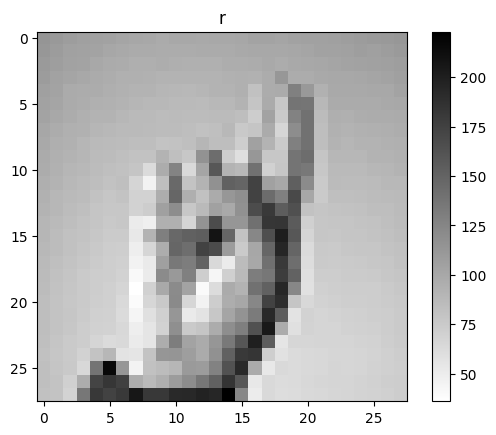

In [7]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다. 
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1) 
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [56]:
x = data.drop('label', axis=1).values
y = data['label'].values

### (2) 데이터 분할2 : train, validation

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1000, random_state=2023)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=2000, random_state=2023)
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((5000, 784), (2000, 784), (1000, 784), (5000,), (2000,), (1000,))

In [58]:
# 모두 넘파이로 변환
type(x_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

### (3) shape 맞추기 n, 28,28,1

* reshape
    * x_train.shape : (-1, 28, 28, 1)
    * x_val.shape : (-1, 28, 28, 1)

In [59]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train.shape, x_val.shape

((5000, 28, 28, 1), (2000, 28, 28, 1))

### (4) Scaling : Min-Max

* 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
* x_train, x_test를 그냥 255로 나누면 됨

In [60]:
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

## 4.모델링

### (1) 모델 설계

In [61]:
clear_session()

# 모델 쌓기
il = Input(shape=(28, 28, 1))

hl = Conv2D(32, (3, 3), activation='relu', padding='same')(il)
hl = Conv2D(32, (3, 3), activation='relu', padding='same')(hl)
hl = BatchNormalization()(hl)
hl = MaxPooling2D()(hl)
hl = Dropout(0.2)(hl)

hl = Conv2D(64, (3, 3), activation='relu', padding='same')(il)
hl = Conv2D(64, (3, 3), activation='relu', padding='same')(hl)
hl = BatchNormalization()(hl)
hl = MaxPooling2D()(hl)
hl = Dropout(0.2)(hl)

hl = Flatten()(hl)
hl = Dense(512, activation='relu')(hl)
hl = Dropout(0.2)(hl)
ol = Dense(26, activation='softmax')(hl)

# 모델 선언
model = Model(il, ol)

# 컴파일
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

# 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0     

### (2) 학습

In [62]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(
    patience=5,
    min_delta=0,
    verbose=1
)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=10, batch_size=256, callbacks=[es])

Epoch 1/10
20/20 [==============================] - 28s 1s/step - loss: 2.0905 - accuracy: 0.4592 - val_loss: 2.9205 - val_accuracy: 0.4230
Epoch 2/10
20/20 [==============================] - 31s 2s/step - loss: 0.4067 - accuracy: 0.8710 - val_loss: 2.6673 - val_accuracy: 0.8270
Epoch 3/10
20/20 [==============================] - 29s 1s/step - loss: 0.0904 - accuracy: 0.9776 - val_loss: 2.4460 - val_accuracy: 0.9525
Epoch 4/10
20/20 [==============================] - 21s 1s/step - loss: 0.0327 - accuracy: 0.9926 - val_loss: 2.2253 - val_accuracy: 0.9755
Epoch 5/10
20/20 [==============================] - 26s 1s/step - loss: 0.0164 - accuracy: 0.9968 - val_loss: 2.0151 - val_accuracy: 0.9845
Epoch 6/10
20/20 [==============================] - 29s 1s/step - loss: 0.0100 - accuracy: 0.9980 - val_loss: 1.8491 - val_accuracy: 0.9755
Epoch 7/10
20/20 [==============================] - 26s 1s/step - loss: 0.0054 - accuracy: 0.9994 - val_loss: 1.6607 - val_accuracy: 0.9720
Epoch 8/10
20/20 [==

### (3) 학습결과 그래프

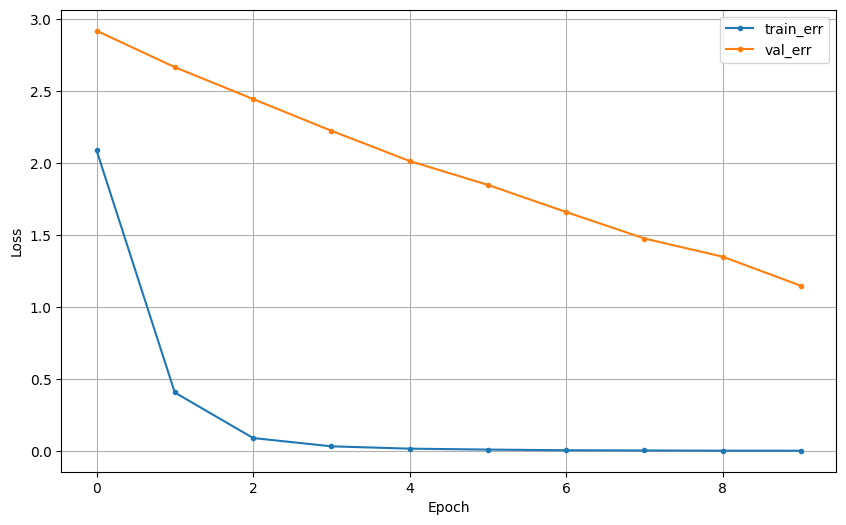

In [63]:
dl_history_plot(history.history)

### (4) 예측 및 검증

In [64]:
y_pred = model.predict(x_test).argmax(axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

32/32 [==============================] - 1s 32ms/step
[[44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 51  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 55  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 43  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 39  0  0

In [65]:
y_pred = model.predict(x_val).argmax(axis=1)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

63/63 [==============================] - 2s 38ms/step
[[87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 78  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 98  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 82  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 89  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 73  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 75  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 82  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 97  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 69  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 80  0  0

## 5.저장하기

* 여기서는 joblib을 이용하여 모델과 데이터셋을 저장하겠습니다.

### (1) 모델 저장하기

In [66]:
path = 'proj1/'

joblib.dump(model, path + 'model.pkl')

['proj1/model.pkl']

### (2) 모델 로딩하기
* 로딩시 model2로 저장합니다.

In [67]:
model2 = joblib.load(path + 'model.pkl')

### (3) test 셋으로 예측하고 평가해보기

* test 셋에 필요한 전처리는 다음과 같습니다.
    * 넘파이 어레이로 변환
    * 4차원 데이터셋으로 변환
    * 스케일링

In [ ]:
#### 헉 위에서 해버림

# 넘파이 어레이로 변환

# 4차원 데이터셋

# 스케일링


In [68]:
# 예측하고 평가하기

y_pred = model2.predict(x_test).argmax(axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

32/32 [==============================] - 1s 18ms/step
[[44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 51  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 55  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 43  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 39  0  0

## 6.Data Pipeline 구성

### (1) 라이브러리 로딩

In [69]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

### (2) 테스트 데이터 로딩
* 제공받은 이미지로 테스트 해보기
* 직접 찍은 사진으로 테스트 해보기

In [70]:
# 파일 열기
path = 'test image/'
file = 'v.png'
filename = path + file

img = cv2.imread(filename)
cv2.imshow('img', img)

cv2.waitKey(0) # 키보드 입력 대기
cv2.destroyAllWindows() # 키보드 입력이 있으면 이미지 창 닫기

### (3) Data Pipeline에 포함되어야 할 절차
* 이미지 크기 맞추기
* 흑백이미지
* 스케일링

#### 1)이미지 읽을 때 흑백으로 읽기

In [71]:
# 파일 열기
img = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)

# 조회는 파이프라인 불필요
print(img.shape)
cv2.imshow('img', img)
cv2.waitKey(0) # 키보드 입력 대기
cv2.destroyAllWindows() # 키보드 입력이 있으면 이미지 창 닫기

(260, 228)


#### 2)이미지 크기를 28, 28, 1 로 맞추기
* 이미지 크기를 조절하는 방법은 크게 두가지 입니다.
    * numpy 
    * opencv의 resize 함수 이용

In [72]:
# 크기 조절하기
img = cv2.resize(img, (28, 28))

# 조회는 파이프라인 불필요
print(img.shape)
cv2.imshow('img', img)
cv2.waitKey(0) # 키보드 입력 대기
cv2.destroyAllWindows() # 키보드 입력이 있으면 이미지 창 닫기

(28, 28)


In [73]:
# 입력데이터 형식을 갖추기 : (1,28,28,1)
img = img.reshape(-1, 28, 28, 1)

#### 3)스케일링

In [74]:
img = img / 255.

#### 4)모델 로딩하기

In [76]:
model2 = joblib.load('proj1/model.pkl')

#### 5)예측하기

In [79]:
y_pred = model2.predict(img).argmax(axis=1)
print(y_pred, class_names[y_pred])

1/1 [==============================] - 0s 29ms/step
[21] ['v']


### (4) 하나의 셀로 합치기

* 코드를 하나로 모으기

In [82]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib
import string

# class names 준비
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)

# 파일 로딩
path = 'test image/'
file = 'v.png'
filename = path + file

# 흑백으로 읽기
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# 크기 조정
img = cv2.resize(img, (28, 28))

# input shape 맞추기
img = img.reshape(-1, 28, 28, 1)

# 스케일링
img = img / 255.

# 모델 로딩
model = joblib.load('proj1/model.pkl')

# 예측
y_pred = model.predict(img).argmax(axis=1)
result = class_names[y_pred]
print(result)

1/1 [==============================] - 0s 98ms/step
['v']


In [83]:
path = 'proj1/'
joblib.dump(class_names, path + 'class_names.pkl')

['proj1/class_names.pkl']